<a href="https://colab.research.google.com/github/abhinavravi1/Deep-Learning-for-Satellite-Image-Analysis/blob/main/dl_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already extracted!
Using dataset directory: /content/EuroSAT
Subset created with 50 images per class.
Found 400 images belonging to 11 classes.
Found 100 images belonging to 11 classes.
Sample batch shapes - Images: (16, 64, 64, 3), Labels: (16, 11)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.1460 - loss: 2.3862 - val_accuracy: 0.1000 - val_loss: 2.2749
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.1564 - loss: 2.2598 - val_accuracy: 0.1700 - val_loss: 2.0793
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.1766 - loss: 2.1421 - val_accuracy: 0.2600 - val_loss: 1.9777
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.1954 - loss: 2.0493 - val_accuracy: 0.3100 - val_loss: 1.9312
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.2246 - loss: 2.0101 - val_accuracy: 0.3200 - val_loss: 1.8222
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.2416 - loss: 1.9754 - val_accuracy: 0.3100 - val_loss: 1.7878
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.2385 - loss: 1.9620 - val_accuracy: 0.2900 - val_loss: 1.8876
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.2576 - loss: 1.9522 - val_accuracy: 0.

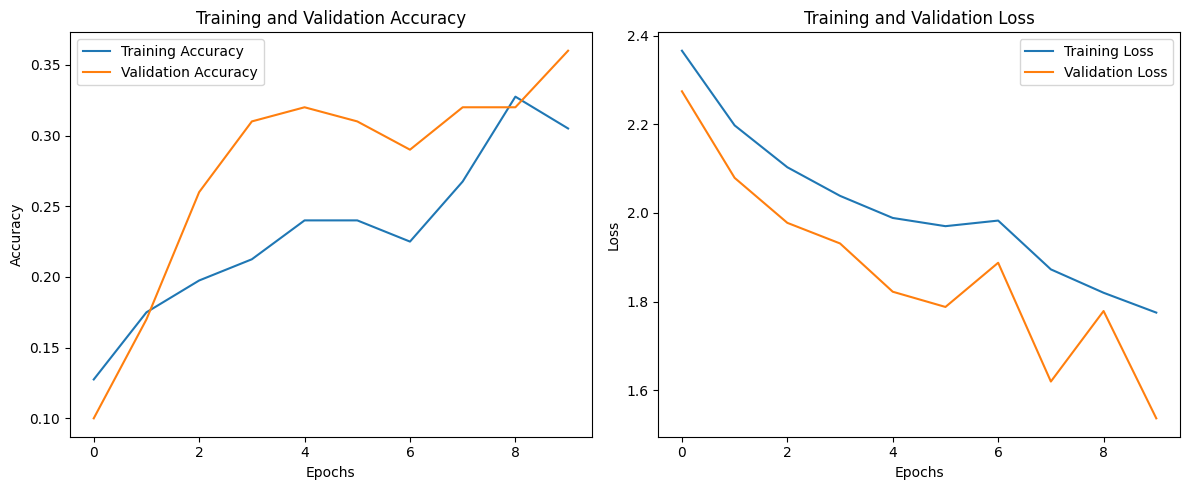

Model plot saved as 'eurosat_cnn_architecture.png'
Validation accuracy: 0.3700
Model saved successfully at /content/drive/My Drive/eurosat_cnn_model.h5.


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import zipfile
import os
import shutil
import random
from google.colab import drive
from tensorflow.keras.utils import plot_model

drive.mount('/content/drive')

dataset_zip_path = "/content/drive/My Drive/EuroSAT.zip"
dataset_base_dir = "/content/EuroSAT"

if not os.path.exists(dataset_base_dir):
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_base_dir)
else:
    print("Dataset already extracted!")

sub_dirs = os.listdir(dataset_base_dir)
if len(sub_dirs) == 1 and os.path.isdir(os.path.join(dataset_base_dir, sub_dirs[0])):
    dataset_dir = os.path.join(dataset_base_dir, sub_dirs[0])
else:
    dataset_dir = dataset_base_dir

subset_dir = "/content/EuroSAT_subset"
os.makedirs(subset_dir, exist_ok=True)

def create_subset(data_dir, subset_path, num_samples=50):
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_subset_path = os.path.join(subset_path, class_name)
            os.makedirs(class_subset_path, exist_ok=True)
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            selected_files = random.sample(image_files, min(num_samples, len(image_files)))
            for file in selected_files:
                src = os.path.join(class_path, file)
                dst = os.path.join(class_subset_path, file)
                shutil.copy(src, dst)

create_subset(dataset_dir, subset_dir, num_samples=50)

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    subset_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    subset_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

images, labels = next(train_gen)

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    verbose=1
)

val_loss, val_acc = model.evaluate(val_gen, verbose=2)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plot_model(model, to_file="eurosat_cnn_architecture.png", show_shapes=True, show_layer_names=True)

print(f"Validation accuracy: {val_acc:.4f}")

model_save_path = '/content/drive/My Drive/eurosat_cnn_model.h5'
model.save(model_save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already extracted!
Using dataset directory: /content/EuroSAT
Subset created with 50 images per class.
Found 796 images belonging to 11 classes.
Found 194 images belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 378ms/step - accuracy: 0.1007 - loss: 2.3823 - val_accuracy: 0.1667 - val_loss: 2.1700
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 324ms/step - accuracy: 0.1406 - loss: 2.2247 - val_accuracy: 0.2135 - val_loss: 1.9804
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - accuracy: 0.1907 - loss: 2.0695 - val_accuracy: 0.2500 - val_loss: 1.9340
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.2125 - loss: 2.0488 - val_accuracy: 0.2552 - val_loss: 1.8660
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - accuracy: 0.2089 - loss: 2.0197 - val_accuracy: 0.2604 - val_loss: 1.8005
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.2236 - loss: 1.9720 - val_accuracy: 0.2865 - val_loss: 1.8123
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 349ms/step - accuracy: 0.2327 - loss: 1.9493 - val_accuracy: 0.3125 - val_loss: 1.8112
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 361ms/step - accuracy: 0.2325 - loss: 1.9158 - val_accura

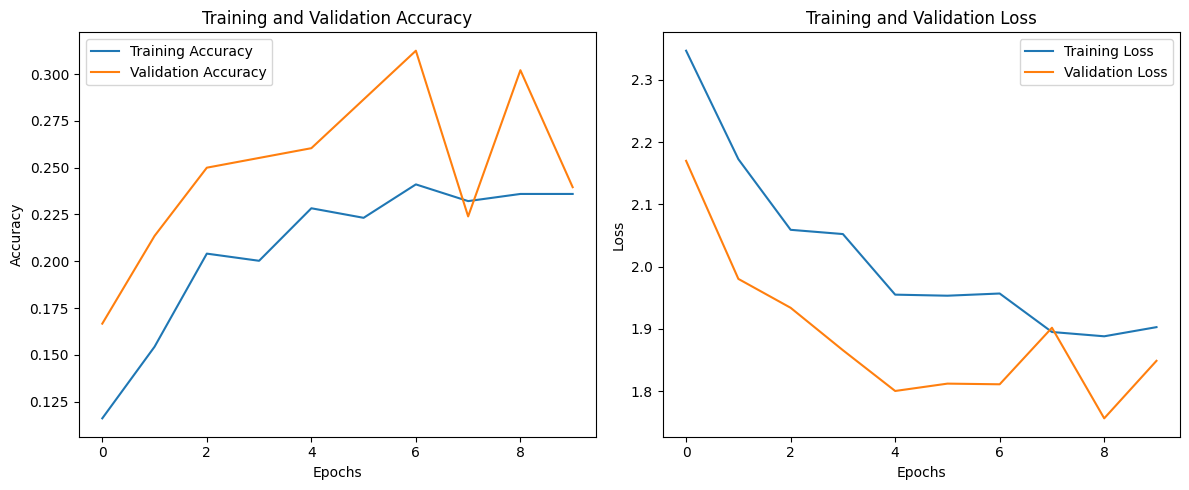

Model saved successfully at /content/drive/My Drive/eurosat_rnn_model.h5.


In [ ]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from google.colab import drive
import zipfile

drive.mount('/content/drive')

dataset_zip_path = "/content/drive/My Drive/EuroSAT.zip"
dataset_base_dir = "/content/EuroSAT"

if not os.path.exists(dataset_base_dir):
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_base_dir)
    print("Dataset extracted successfully!")
else:
    print("Dataset already extracted!")

sub_dirs = os.listdir(dataset_base_dir)
if len(sub_dirs) == 1 and os.path.isdir(os.path.join(dataset_base_dir, sub_dirs[0])):
    dataset_dir = os.path.join(dataset_base_dir, sub_dirs[0])
else:
    dataset_dir = dataset_base_dir

print(f"Using dataset directory: {dataset_dir}")

subset_dir = "/content/EuroSAT_subset"
os.makedirs(subset_dir, exist_ok=True)

def create_subset(data_dir, subset_path, num_samples=50):
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_subset_path = os.path.join(subset_path, class_name)
            os.makedirs(class_subset_path, exist_ok=True)
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            selected_files = random.sample(image_files, min(num_samples, len(image_files)))
            for file in selected_files:
                src = os.path.join(class_path, file)
                dst = os.path.join(class_subset_path, file)
                shutil.copy(src, dst)

create_subset(dataset_dir, subset_dir, num_samples=50)
print("Subset created with 50 images per class.")

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    subset_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    subset_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_gen.class_indices)

def preprocess_rnn_data(generator):
    data = []
    labels = []
    for x_batch, y_batch in generator:
        x_batch = x_batch.reshape(x_batch.shape[0], x_batch.shape[1], -1)
        data.append(x_batch)
        labels.append(y_batch)
        if len(data) >= generator.samples // generator.batch_size:
            break
    return np.vstack(data), np.vstack(labels)

x_train, y_train = preprocess_rnn_data(train_gen)
x_val, y_val = preprocess_rnn_data(val_gen)

model = Sequential([
    LSTM(256, input_shape=(64, 64 * 3), activation='tanh', return_sequences=True),
    Dropout(0.4),
    LSTM(128, activation='tanh'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_model(
    model,
    to_file="rnn_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)

history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)

val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Validation accuracy: {val_accuracy:.2f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model_save_path = '/content/drive/My Drive/eurosat_rnn_model.h5'
model.save(model_save_path)
print(f"Model saved successfully at {model_save_path}.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0270 - val_loss: 0.0148
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0159 - val_loss: 0.0165
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0157 - val_loss: 0.0147
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0154 - val_loss: 0.0146
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0143 - val_loss: 0.0156
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0133 - val_loss: 0.0161
Epoch 1/10
74/74 ━━━

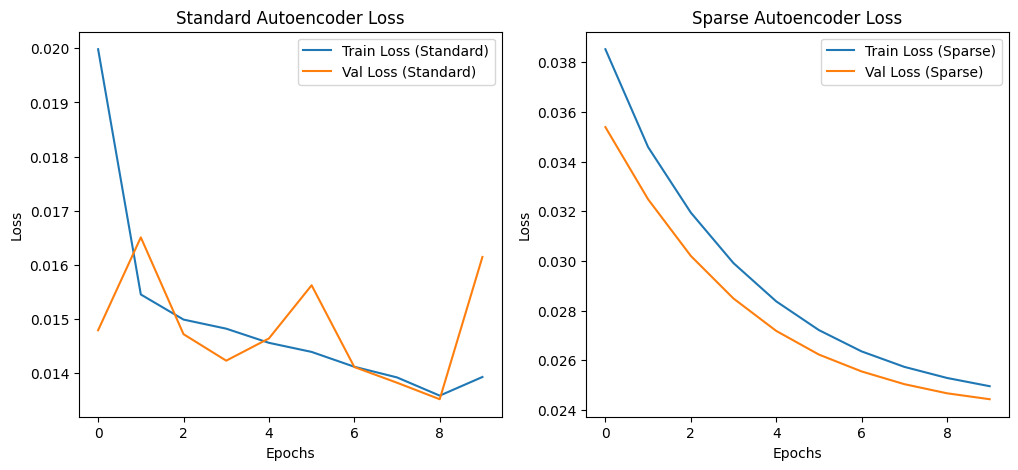

In [ ]:
#Standard and Sparse Autoencoder
import os
import cv2
import numpy as np
import shutil
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from google.colab import drive

drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/archive.zip"
unzip_path = "/content/EuroSAT"

if not os.path.exists(unzip_path):
    !unzip -q "{dataset_path}" -d "/content/"

subset_path = os.path.join(unzip_path, "EuroSAT_subset")
os.makedirs(subset_path, exist_ok=True)

def create_subset(data_dir, subset_dir, num_samples_per_class=50):
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        if not os.path.isdir(class_path):
            continue
        class_subset_path = os.path.join(subset_dir, class_dir)
        os.makedirs(class_subset_path, exist_ok=True)
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        selected_files = random.sample(image_files, min(len(image_files), num_samples_per_class))
        for file in selected_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(class_subset_path, file)
            shutil.copy(src, dst)

create_subset(unzip_path, subset_path)

IMG_SIZE = (64, 64)
X, y = [], []
class_labels = {class_name: idx for idx, class_name in enumerate(sorted(os.listdir(subset_path))) if os.path.isdir(os.path.join(subset_path, class_name))}

for class_name in class_labels:
    class_path = os.path.join(subset_path, class_name)
    label = class_labels[class_name]
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        y.append(label)

X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_autoencoder(l1_reg=0.0):
    input_layer = Input(shape=(64, 64, 3))
    x = Flatten()(input_layer)
    encoded = Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l1(l1_reg))(x)
    decoded = Dense(64 * 64 * 3, activation='sigmoid')(encoded)
    decoded = tf.keras.layers.Reshape((64, 64, 3))(decoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

autoencoder_std, encoder_std = build_autoencoder(l1_reg=0.0)
autoencoder_sparse, encoder_sparse = build_autoencoder(l1_reg=10e-5)

history_std = autoencoder_std.fit(X_train, X_train, epochs=10, batch_size=16, validation_data=(X_test, X_test), verbose=1)
history_sparse = autoencoder_sparse.fit(X_train, X_train, epochs=10, batch_size=16, validation_data=(X_test, X_test), verbose=1)

X_train_features_std = encoder_std.predict(X_train)
X_test_features_std = encoder_std.predict(X_test)
X_train_features_sparse = encoder_sparse.predict(X_train)
X_test_features_sparse = encoder_sparse.predict(X_test)

scaler = StandardScaler()
X_train_features_std = scaler.fit_transform(X_train_features_std)
X_test_features_std = scaler.transform(X_test_features_std)
X_train_features_sparse = scaler.fit_transform(X_train_features_sparse)
X_test_features_sparse = scaler.transform(X_test_features_sparse)

svm_std = SVC(kernel='linear')
svm_std.fit(X_train_features_std, y_train)
y_pred_std = svm_std.predict(X_test_features_std)
accuracy_std = accuracy_score(y_test, y_pred_std)

svm_sparse = SVC(kernel='linear')
svm_sparse.fit(X_train_features_sparse, y_train)
y_pred_sparse = svm_sparse.predict(X_test_features_sparse)
accuracy_sparse = accuracy_score(y_test, y_pred_sparse)

print(f"Accuracy by Autoencoder (w/o L1) features: {accuracy_std * 100:.2f}%")
print(f"Accuracy by Sparse Autoencoder (w L1) features: {accuracy_sparse * 100:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_std.history['loss'], label='Train Loss (Standard)')
plt.plot(history_std.history['val_loss'], label='Val Loss (Standard)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Standard Autoencoder Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_sparse.history['loss'], label='Train Loss (Sparse)')
plt.plot(history_sparse.history['val_loss'], label='Val Loss (Sparse)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Sparse Autoencoder Loss')
plt.legend()

plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 42s 319ms/step - loss: 0.0217 - val_loss: 0.0120
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 38s 315ms/step - loss: 0.0125 - val_loss: 0.0089
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 42s 326ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 45s 370ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 81s 364ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 44s 365ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 9/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 81s 357ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 10/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 85s 379ms/step - loss: 0.0049

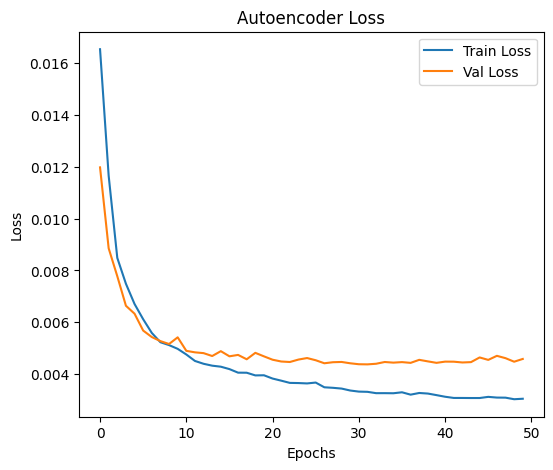

In [ ]:
#Autoencoders
import os
import cv2
import numpy as np
import shutil
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from google.colab import drive

drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/archive.zip"
unzip_path = "/content/EuroSAT"

if not os.path.exists(unzip_path):
    !unzip -q "{dataset_path}" -d "/content/"

subset_path = os.path.join(unzip_path, "EuroSAT_subset")
os.makedirs(subset_path, exist_ok=True)

def create_subset(data_dir, subset_dir, num_samples_per_class=100):
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        if not os.path.isdir(class_path):
            continue
        class_subset_path = os.path.join(subset_dir, class_dir)
        os.makedirs(class_subset_path, exist_ok=True)
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        selected_files = random.sample(image_files, min(len(image_files), num_samples_per_class))
        for file in selected_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(class_subset_path, file)
            shutil.copy(src, dst)

create_subset(unzip_path, subset_path)

IMG_SIZE = (64, 64)
X, y = [], []
class_labels = {class_name: idx for idx, class_name in enumerate(sorted(os.listdir(subset_path))) if os.path.isdir(os.path.join(subset_path, class_name))}

for class_name in class_labels:
    class_path = os.path.join(subset_path, class_name)
    label = class_labels[class_name]
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        y.append(label)

X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_autoencoder(l1_reg=0.0):
    input_layer = Input(shape=(64, 64, 3))
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l1(l1_reg))(x)
    x = Dense(4096, activation='relu')(encoded)
    x = tf.keras.layers.Reshape((16, 16, 16))(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

autoencoder_std, encoder_std = build_autoencoder(l1_reg=0.0)

history_std = autoencoder_std.fit(X_train, X_train, epochs=50, batch_size=16, validation_data=(X_test, X_test), verbose=1)

X_train_features_std = encoder_std.predict(X_train)
X_test_features_std = encoder_std.predict(X_test)

scaler = StandardScaler()
X_train_features_std = scaler.fit_transform(X_train_features_std)
X_test_features_std = scaler.transform(X_test_features_std)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train_features_std, y_train)
y_pred = clf.predict(X_test_features_std)
accuracy = accuracy_score(y_test, y_pred)

print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

plt.figure(figsize=(6, 5))
plt.plot(history_std.history['loss'], label='Train Loss')
plt.plot(history_std.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder Loss')
plt.legend()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available Classes: ['HerbaceousVegetation', 'Industrial', 'Forest', 'PermanentCrop', 'Pasture', 'Highway', 'Residential', 'River', 'SeaLake', 'AnnualCrop']


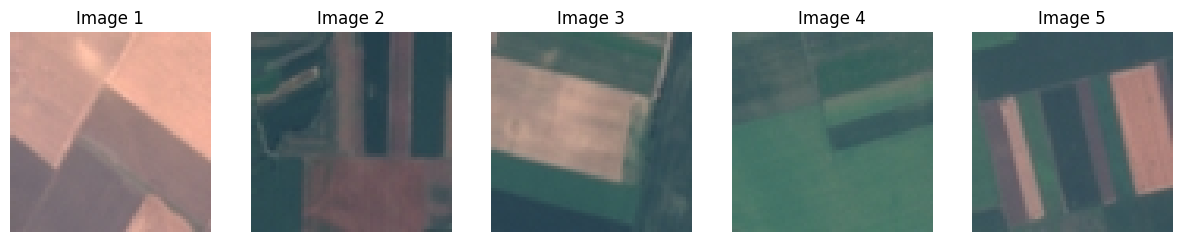

In [ ]:

import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import random
from google.colab import drive

zip_path = "/content/drive/My Drive/archive.zip"
extract_path = "/content/EuroSAT/EuroSAT/"

drive.mount('/content/drive')

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/EuroSAT/")

if not os.path.exists(extract_path):
    raise FileNotFoundError(f"Dataset not found at {extract_path}.")

class_names = [d for d in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, d))]
print("Available Classes:", class_names)

selected_class = "AnnualCrop"

class_path = os.path.join(extract_path, selected_class)
if not os.path.exists(class_path):
    raise FileNotFoundError(f"Class '{selected_class}' not found.")

image_files = os.listdir(class_path)
if not image_files:
    raise ValueError(f"No images found in {class_path}")

num_images = min(5, len(image_files))
sample_images = random.sample(image_files, num_images)

fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(class_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Image {i+1}")

plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available classes: ['HerbaceousVegetation', 'Industrial', 'Forest', 'PermanentCrop', 'Pasture', 'Highway', 'Residential', 'River', 'SeaLake', 'AnnualCrop']
Using class: HerbaceousVegetation
Total images in selected class (HerbaceousVegetation): 3000
[d1_g1] Epoch [1/50] - D Loss: 0.0243 - G Loss: 6.1774
[d1_g1] Epoch [2/50] - D Loss: 0.0226 - G Loss: 5.4235
[d1_g1] Epoch [3/50] - D Loss: 0.0041 - G Loss: 6.5504
[d1_g1] Epoch [4/50] - D Loss: 0.0011 - G Loss: 7.5550
[d1_g1] Epoch [5/50] - D Loss: 0.0036 - G Loss: 6.4611
[d1_g1] Epoch [6/50] - D Loss: 0.0025 - G Loss: 6.5497
[d1_g1] Epoch [7/50] - D Loss: 0.0069 - G Loss: 5.9458
[d1_g1] Epoch [8/50] - D Loss: 0.0107 - G Loss: 6.2288
[d1_g1] Epoch [9/50] - D Loss: 0.0141 - G Loss: 5.2591
[d1_g1] Epoch [10/50] - D Loss: 0.0456 - G Loss: 4.5889
[d1_g1] Epoch [11/50] - D Loss: 0.0134 - G Loss: 7.5564
[d1_g1] Epoch 

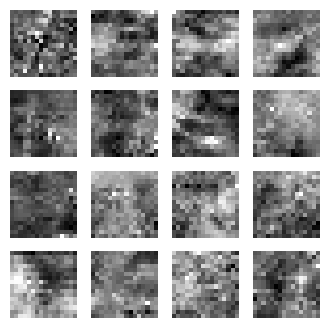

In [ ]:
#Generative Adversarial Networks
import os
import cv2
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from google.colab import drive
from torchvision.utils import make_grid

drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/archive.zip"
unzip_path = "/content/EuroSAT"

if not os.path.exists(unzip_path):
    !unzip -q "/content/drive/My Drive/archive.zip" -d "/content/"

eurosat_path = os.path.join(unzip_path, "EuroSAT")
class_folders = [d for d in os.listdir(eurosat_path) if os.path.isdir(os.path.join(eurosat_path, d))]
print("Available classes:", class_folders)

selected_class = class_folders[0]
print(f"Using class: {selected_class}")

class_path = os.path.join(eurosat_path, selected_class)
image_files = os.listdir(class_path)
print(f"Total images in selected class ({selected_class}): {len(image_files)}")

class EuroSATDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_files = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (16, 16))

        if self.transform:
            img = self.transform(img)
        return img, 0

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = EuroSATDataset(class_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

image_size = 16
z_dim = 64
lr = 0.0002
epochs = 50

class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, z_dim, 1, 1)
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.net(img)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

def train_gan(dataloader, d_updates, g_updates, epochs, experiment_label):
    start_time = time.time()
    for epoch in range(epochs):
        for real_imgs, _ in dataloader:
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            for _ in range(d_updates):
                z = torch.randn(batch_size, z_dim, device=device)
                fake_imgs = generator(z).detach()

                real_labels = torch.ones(batch_size, 1, device=device)
                fake_labels = torch.zeros(batch_size, 1, device=device)

                d_loss_real = criterion(discriminator(real_imgs), real_labels)
                d_loss_fake = criterion(discriminator(fake_imgs), fake_labels)
                d_loss = d_loss_real + d_loss_fake

                optimizer_d.zero_grad()
                d_loss.backward()
                optimizer_d.step()

            for _ in range(g_updates):
                z = torch.randn(batch_size, z_dim, device=device)
                fake_imgs = generator(z)
                g_loss = criterion(discriminator(fake_imgs), real_labels)

                optimizer_g.zero_grad()
                g_loss.backward()
                optimizer_g.step()

        print(f"[{experiment_label}] Epoch [{epoch+1}/{epochs}] - D Loss: {d_loss.item():.4f} - G Loss: {g_loss.item():.4f}")
    end_time = time.time()
    return end_time - start_time

d_updates_list = [1, 2, 3]
g_updates_list = [1, 2, 3]

for d_updates in d_updates_list:
    for g_updates in g_updates_list:
        train_time = train_gan(dataloader, d_updates, g_updates, epochs, f"d{d_updates}_g{g_updates}")
        print(f"Training time for d_updates={d_updates}, g_updates={g_updates}: {train_time:.2f} seconds")

generator.eval()
z = torch.randn(16, z_dim, device=device)
with torch.no_grad():
    samples = generator(z).cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i, 0], cmap="gray")
    ax.axis("off")
plt.show()
